In [1]:
import torch
import torch.nn as nn
from torchvision.transforms.functional import to_pil_image
from torchvision.utils import make_grid
from core.datasets import fetch_dataloader
from lescroartdata import fetch_dataloader_lesc
import core.utils.sync_batchnorm as sync_batchnorm
from core.eisen import EISEN
from core.raft import EvalRAFT
from types import SimpleNamespace
from collections import OrderedDict
import matplotlib.pyplot as plt
import numpy as np

%load_ext autoreload
%autoreload 2

/home/galdegh/.conda/envs/eisen/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False, figsize=(30, 10))
    for i, img in enumerate(imgs):
        img = img.detach()
        img = to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [3]:
args = SimpleNamespace(
        dataset='playroom',
        batch_size=2,
        num_workers=1,
        compute_flow=True,
        precompute_flow=False,
        flow_threshold=0.5
    )

In [4]:
device = torch.device("cuda:1")
#device = torch.device("cpu")

In [5]:
val_loader = fetch_dataloader(args)
model = EISEN(device=device)
raft_model = EvalRAFT(flow_threshold=args.flow_threshold, device=device)

In [6]:
state_dict = torch.load('pretrained/tdw_playroom_128x128_ckpt.pth', map_location=device)

In [7]:
new_state_dict = OrderedDict()

for k, v in state_dict.items():
    name = k[7:] # remove `module.`
    new_state_dict[name] = v

In [8]:
model.load_state_dict(new_state_dict)
model.eval()

EISEN(
  (backbone): ResNet_Deeplab(
    (decoder): ModuleDict(
      (res2): ModuleDict(
        (project_conv): Conv2d(256, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (fuse_conv): Sequential(
          (0): Conv2d(160, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
      )
      (res3): ModuleDict(
        (project_conv): Conv2d(512, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (fuse_conv): Sequential(
          (0): Conv2d(320, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
      )
      (res5): ModuleDict(
        (project_conv): ASPP(
          (convs): ModuleList(
            (0): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): Conv2d(2048, 256, kernel_size=(3, 3), stri

In [9]:
data_dict = next(iter(val_loader))
data_dict = {k: v.to(device) for k, v in data_dict.items() if not k == 'file_name'}

In [ ]:
data_dict['gt_segment'].shape

In [ ]:
data_dict['gt_segment'] = torch.randint(4, data_dict['gt_segment'].shape, dtype=torch.int64, device=device)

In [10]:
with torch.no_grad():
       _, _, segment_target = raft_model(data_dict['img1'], data_dict['img2'])

/home/galdegh/.conda/envs/eisen/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [ ]:
segment_target.shape

In [ ]:
grid = make_grid(segment_target.type(torch.uint8)*255)

In [ ]:
show(grid)

In [ ]:
grid = make_grid(data_dict['img1'])

In [ ]:
show(grid)

In [ ]:
_, loss, metric, seg_out = model(data_dict, segment_target.detach(),
                                 get_segments=True, vis_segments=False)

In [11]:
def visualize_segments(seg_out, input):
    batch_size = len(seg_out[0])
    num_objects = len(seg_out[0][0])
    pred_obj_seg, gt_obj_seg, iou = seg_out
    fig, axs = plt.subplots(batch_size, num_objects + 1, 
                            figsize=(3*(num_objects + 1), 3*batch_size))
    
    for m in range(batch_size):
        axs[m, 0].imshow(input['img1'][m].permute(1, 2, 0).cpu())
        for n in range(num_objects):
            #if n + 1 <= len(pred_obj_seg[m]): 
            axs[m, n + 1].imshow(pred_obj_seg[m][n])
            
    for i in range(axs.shape[0]):
        for j in range(axs.shape[1]):
            axs[i, j].set_axis_off()
    
    plt.show()

In [ ]:
visualize_segments(seg_out['pred_segment'], data_dict)

In [ ]:
segment_target.shape

## Lescroart data

In [13]:
args = SimpleNamespace(batch_size=2)
lesc_loader = fetch_dataloader_lesc(args)

In [14]:
len(lesc_loader)

5

In [18]:
data_dict_lesc = next(iter(lesc_loader))
data_dict_lesc['gt_segment'] = torch.randint(4, (args.batch_size, 512, 512), dtype=torch.int64, device=device)
data_dict_lesc = {k: v.to(device) for k, v in data_dict_lesc.items() if not k == 'file_name'}

In [19]:
_, loss, metric, seg_out = model(data_dict_lesc, segment_target.detach(),
                                 get_segments=True, vis_segments=False)

/home/galdegh/.conda/envs/eisen/lib/python3.9/site-packages/torch_sparse/storage.py:14: UserWarning: `layout` argument unset, using default layout "coo". This may lead to unexpected behaviour.
  warnings.warn('`layout` argument unset, using default layout '
/home/galdegh/.conda/envs/eisen/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/galdegh/.conda/envs/eisen/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


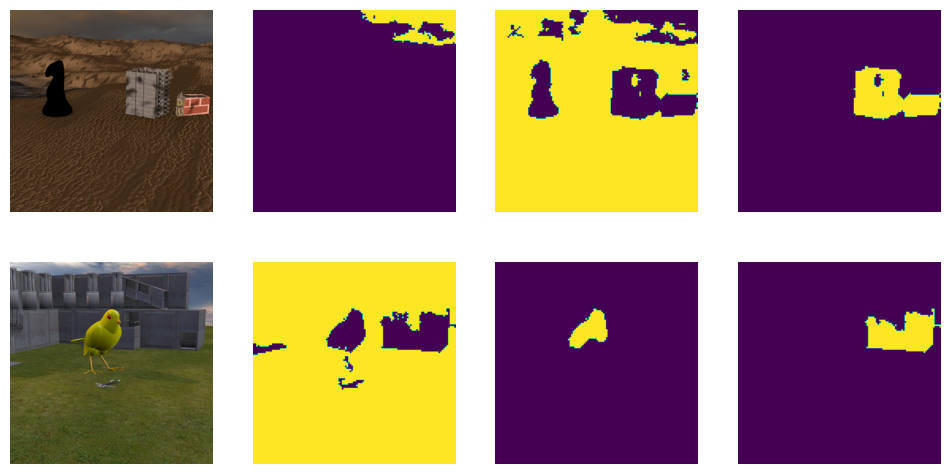

In [20]:
visualize_segments(seg_out['pred_segment'], data_dict_lesc)

In [ ]:
visualize_segments(seg_out['pred_segment'], data_dict_lesc)

In [ ]:
type(seg_out['pred_segment'][0][0][0])

In [ ]:
len(seg_out['pred_segment'])

In [ ]:
for ps in seg_out['pred_segment']:
    print(len(ps))
    for i in ps:
        print(len(i))

In [ ]:
grid = make_grid(seg_out['pred_segment'])
show(grid)